In [ ]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

11.8


In [ ]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.1.0+cu118


In [ ]:

# Use the above information to fill in the http address below
%%capture
!pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric

In [ ]:
# !pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install torch-geometric

In [ ]:
# import gc

import torch
import torch.nn.functional as F
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric.transforms as T
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric import utils, loader


# importing obg datatset
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

from pandas.core.common import flatten
# import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(16.7,8.27)})
# sns.set_theme(style="ticks")

from tqdm import tqdm
import collections
import os.path as osp
import pandas as pd
import numpy as np
import collections
# from pandas.core.common import flatten
# from scipy.special import softmax


In [ ]:
opt = 'MLP'

In [ ]:
# Load the OGB evaluator for the dataset
evaluator = Evaluator(name='ogbn-products')

# Establish the device for model training 'cuda' if GPU, 'cpu' otherwise
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Confirm the device. If it's a GPU, 'cuda' will print
print('Device: {}'.format(device))

Device: cuda


In [ ]:
# download and loading the obg dataset
root = osp.join(osp.dirname(osp.realpath('./')), 'data', 'products')
if opt == 'GCN':
  dataset = PygNodePropPredDataset( name='ogbn-products', root=root)
else:
  dataset = PygNodePropPredDataset( name='ogbn-products', transform=T.ToSparseTensor(), root=root)

Downloaded 1.38 GB: 100%|██████████| 1414/1414 [00:49<00:00, 28.42it/s]


Extracting /data/products/products.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 438.23it/s]


Saving...


Done!


In [ ]:
split_idx = dataset.get_idx_split()
data = dataset[0]


# Part II. MLP

For the exploratory data analysis, we will:


1.   Setup GCN
2.   Setup GraphSage
3.   Setup the training routine

*italicised text*

In [ ]:
data.num_features

100

In [ ]:
data.size(-1)

2449029

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropou):
        super().__init__()
        self.dropout = dropout

        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x = data.x
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.lin2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.lin3(x)
        return torch.log_softmax(x, dim=-1)


In [ ]:
y_true = data.y.to(device)
train_idx = split_idx['train'].to(device)
valid_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

In [ ]:
def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
def validate(model, data, valid_idx):
    model.eval()

    with torch.no_grad():
        out = model(data)[valid_idx]
        valid_loss = F.nll_loss(out, data.y.squeeze(1)[valid_idx])

    return valid_loss.item()


In [ ]:
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']

    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']

    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc


In [ ]:
epochs = 100
hidden_channels = 256
num_classes = len(y_true.unique())
dropout = 0.1
lr = 1e-2
model = MLP(data.num_features, hidden_channels, num_classes,
            dropout).to(device)

evaluator = Evaluator(name='ogbn-products')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
data = data.to(device)


In [ ]:
if opt == 'MLP':
  mlp_loss = []

  # Initialize early stopping variables
  best_valid_loss = float('inf')
  patience = 0
  patience_opt = 5
  max_patience = 10  # Max number of epochs to wait for improvement

  # Initialize learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                patience=patience_opt,
                                verbose=True)

  # Training loop
  with tqdm(range(1, 1 + epochs)) as t:
      for epoch in t:
          # Training
          train_loss = train(model, data, train_idx, optimizer)

          # Validate
          valid_loss = validate(model, data, valid_idx)

          # Accuracy
          train_acc, valid_acc, _ = test(model, data, split_idx, evaluator)

          # Update learning rate
          scheduler.step(valid_loss)

          # Early stopping
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              patience = 0
          else:
              patience += 1
              if patience >= max_patience:
                  print("Early stopping.")
                  break

          t.set_postfix({'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Acc': train_acc, 'Valid Acc': valid_acc})
          mlp_loss.append([train_loss,valid_loss, train_acc,valid_acc])

100%|██████████| 100/100 [18:49<00:00, 11.29s/it, Train Loss=0.79, Valid Loss=0.871, Train Acc=0.791, Valid Acc=0.749]


In [ ]:
if opt == 'MLP':
  # Testing
  test_loss = validate(model, data, test_idx)
  print(f"Epoch {epoch}, Test Loss: {valid_loss}")

  # Accuracy
  _, _, test_acc = test(model, data, split_idx, evaluator)
  print(f"Epoch {epoch}, Test acc: {test_acc}")


Epoch 100, Test Loss: 0.8707842230796814
Epoch 100, Test acc: 0.6088547646707704


In [ ]:
torch.cuda.empty_cache()

NameError: ignored

# Part III. GCN


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2, normalize=True):
        super().__init__()

        self.dropout = dropout
        self.conv1 = GCNConv(in_dim, hidden_dim, normalize=normalize)
        self.conv2 = GCNConv(hidden_dim, hidden_dim , normalize=normalize)
        self.conv3 = GCNConv(hidden_dim, out_dim , normalize=normalize)

    def forward(self, data):
        x, adj_t = data.x, data.adj_t

        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout,  training=self.training)

        x = self.conv2(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)

        return torch.log_softmax(x, dim=-1)

In [ ]:
opt = 'GCN'
opt

'GCN'

In [ ]:
if opt == 'GCN':
  dataset = PygNodePropPredDataset( name='ogbn-products', root=root)

split_idx = dataset.get_idx_split()
data = dataset[0]

In [ ]:
if opt == 'GCN':
    gcn_loss = []
    epochs = 100
    model = GCN(data.num_features, hidden_channels, num_classes,
                dropout).to(device)

    data = data.to(device)


    evaluator = Evaluator(name='ogbn-products')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    edge_index = data.edge_index
    num_nodes = edge_index.max().item() + 1  # Assuming node indices start from 0

    # Compute in-degree for each node
    deg = torch.zeros(num_nodes, dtype=torch.float).to(edge_index.device)
    deg.scatter_add_(0, edge_index[1], torch.ones(edge_index.size(1)).to(edge_index.device))

    # Compute deg_inv_sqrt
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

    # Create a new edge_weight tensor
    edge_weight = torch.ones(edge_index.size(1)).to(edge_index.device)

    # Apply deg_inv_sqrt to edge weights
    edge_weight = deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]

    num_nodes = edge_index.max().item() + 1  # Assuming node indices start from 0

    # Create a sparse tensor and assign to data
    adj_t = torch.sparse_coo_tensor(indices=edge_index, values=edge_weight, size=(num_nodes, num_nodes))
    data.adj_t = adj_t.coalesce()

In [ ]:
if opt == 'GCN':
  best_valid_loss = float('inf')
  patience = 0
  # Initialize learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                patience=patience_opt,
                                verbose=True)

  # Training loop
  with tqdm(range(1, 1 + epochs)) as t:
      for epoch in t:
          # Training
          train_loss = train(model, data, train_idx, optimizer)

          # Validate
          valid_loss = validate(model, data, valid_idx)

          # Accuracy
          train_acc, valid_acc, _ = test(model, data, split_idx, evaluator)

          # Update learning rate
          scheduler.step(valid_loss)

          # Early stopping
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              patience = 0
          else:
              patience += 1
              if patience >= max_patience:
                  print("Early stopping.")
                  break

          t.set_postfix({'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Acc': train_acc, 'Valid Acc': valid_acc})
          gcn_loss.append([train_loss,valid_loss, train_acc,valid_acc])

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/spmm.py:68: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/spmm.py:72: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  src = src.to_sparse_csr()
 76%|███████▌  | 76/100 [04:09<01:18,  3.28s/it, Train Loss=0.906, Valid Loss=0.959, Train Acc=0.796, Valid Acc=0.785]

Epoch 00076: reducing learning rate of group 0 to 1.0000e-03.


 85%|████████▌ | 85/100 [04:39<00:49,  3.28s/it, Train Loss=0.9, Valid Loss=0.958, Train Acc=0.797, Valid Acc=0.785]

Epoch 00085: reducing learning rate of group 0 to 1.0000e-04.


 97%|█████████▋| 97/100 [05:18<00:09,  3.28s/it, Train Loss=0.9, Valid Loss=0.954, Train Acc=0.797, Valid Acc=0.786]

Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [05:28<00:00,  3.28s/it, Train Loss=0.902, Valid Loss=0.956, Train Acc=0.798, Valid Acc=0.786]


In [ ]:
if opt == 'GCN':
  # Testing
  test_loss = validate(model, data, test_idx)
  print(f"Epoch {epoch}, Test Loss: {valid_loss}")

  # Accuracy
  _, _, test_acc = test(model, data, split_idx, evaluator)
  print(f"Epoch {epoch}, Test acc: {test_acc}")


Epoch 100, Test Loss: 0.955582320690155
Epoch 100, Test acc: 0.6274943054759158


In [ ]:
torch.cuda.empty_cache()

# Part IV. GraphSage


In [ ]:
opt = 'GraphSAGE'

In [ ]:
if opt == 'GCN':
  dataset = PygNodePropPredDataset( name='ogbn-products', root=root)
else:
  dataset = PygNodePropPredDataset( name='ogbn-products', transform=T.ToSparseTensor(), root=root)

split_idx = dataset.get_idx_split()
data = dataset[0]

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)

    def forward(self, data):
        x, adj_t = data.x, data.adj_t
        x = self.conv1(x, adj_t)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)

        x = self.conv2(x, adj_t)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)

        x = self.conv3(x, adj_t)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)

        return torch.log_softmax(x, dim=-1)

In [ ]:
model = GraphSAGE(data.num_features, hidden_channels, num_classes,
            dropout).to(device)

evaluator = Evaluator(name='ogbn-products')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
data = data.to(device)
# model(data)


In [ ]:
sage_loss = []

In [ ]:
if opt == 'GraphSAGE':
  # Initialize early stopping variables
  best_valid_loss = float('inf')

  # Initialize learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                patience=patience_opt,
                                verbose=True)

  # Training loop
  with tqdm(range(1, 1 + epochs)) as t:
      for epoch in t:
          # Training
          train_loss = train(model, data, train_idx, optimizer)

          # Validate
          valid_loss = validate(model, data, valid_idx)

          # Accuracy
          train_acc, valid_acc, _ = test(model, data, split_idx, evaluator)

          # Update learning rate
          scheduler.step(valid_loss)

          # Early stopping
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              patience = 0
          else:
              patience += 1
              if patience >= max_patience:
                  print("Early stopping.")
                  break

          t.set_postfix({'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Acc': train_acc, 'Valid Acc': valid_acc})
          sage_loss.append([train_loss,valid_loss, train_acc,valid_acc])

In [ ]:
if opt == 'GraphSAGE':
  # Testing
  test_loss = validate(model, data, test_idx)
  print(f"Epoch {epoch}, Test Loss: {valid_loss}")

  # Accuracy
  _, _, test_acc = test(model, data, split_idx, evaluator)
  print(f"Epoch {epoch}, Test acc: {test_acc}")


Epoch 93, Test Loss: 0.6743821501731873
Epoch 93, Test acc: 0.7091642413258199


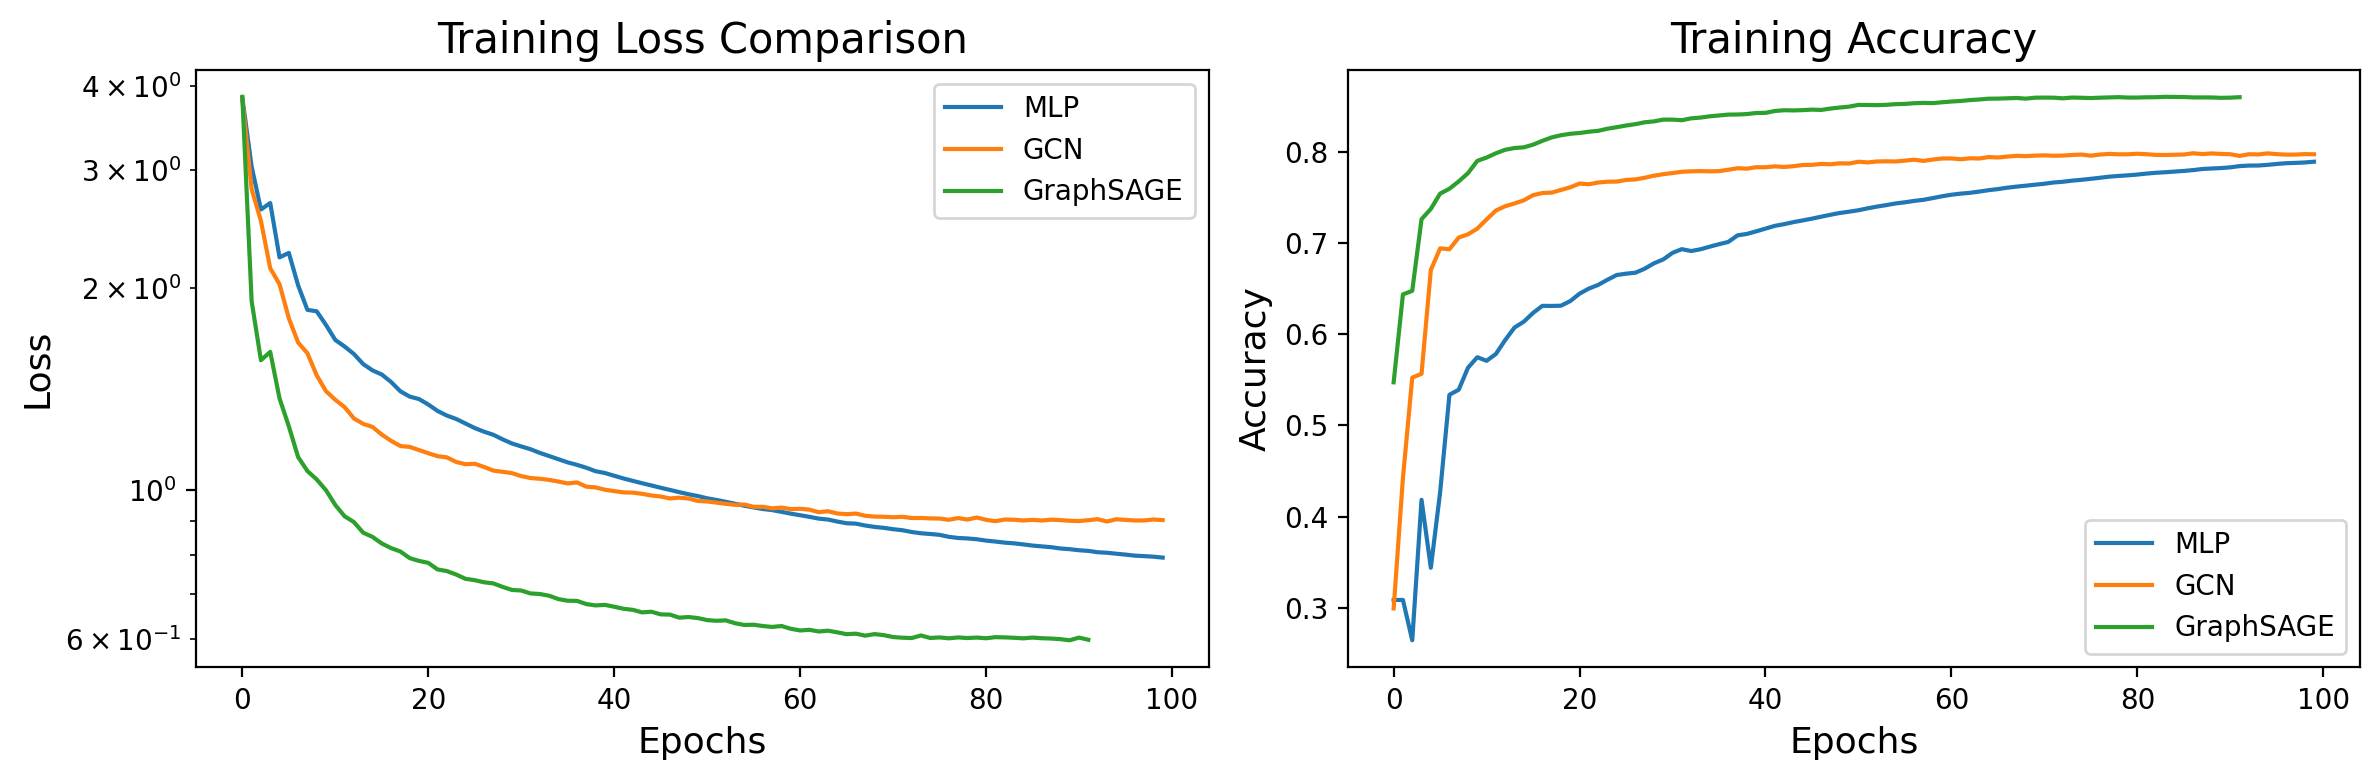

In [ ]:

# Unpack values
mlp_train_loss, mlp_valid_loss, mlp_train_acc, mlp_valid_acc = zip(*mlp_loss)
gcn_train_loss, gcn_valid_loss, gcn_train_acc, gcn_valid_acc = zip(*gcn_loss)
sage_train_loss, sage_valid_loss, sage_train_acc, sage_valid_acc = zip(*sage_loss)

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=200)
label_size = 13
title_size = 15
# Plotting Loss
axs[0].semilogy(mlp_train_loss, label='MLP')
axs[0].semilogy(gcn_train_loss, label='GCN')
axs[0].semilogy(sage_train_loss, label='GraphSAGE')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend()
axs[0].set_title('Training Loss Comparison', fontsize=title_size)

# Plotting Accuracy
axs[1].plot(mlp_train_acc, label='MLP')
axs[1].plot(gcn_train_acc, label='GCN')
axs[1].plot(sage_train_acc, label='GraphSAGE')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend()
axs[1].set_title('Training Accuracy', fontsize=title_size)

plt.tight_layout()
plt.show()

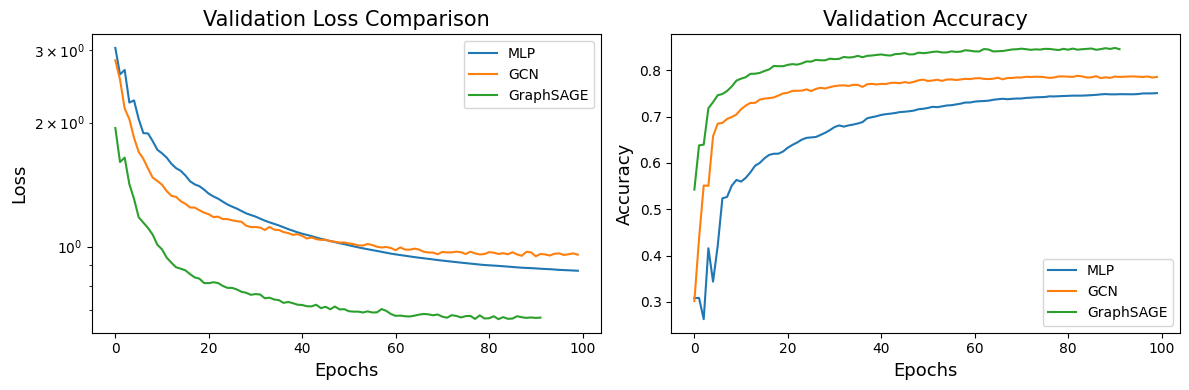

In [ ]:

# Unpack values
mlp_train_loss, mlp_valid_loss, mlp_train_acc, mlp_valid_acc = zip(*mlp_loss)
gcn_train_loss, gcn_valid_loss, gcn_train_acc, gcn_valid_acc = zip(*gcn_loss)
sage_train_loss, sage_valid_loss, sage_train_acc, sage_valid_acc = zip(*sage_loss)

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Plotting Validation Loss
axs[0].semilogy(mlp_valid_loss, label='MLP')
axs[0].semilogy(gcn_valid_loss, label='GCN')
axs[0].semilogy(sage_valid_loss, label='GraphSAGE')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend()
axs[0].set_title('Validation Loss Comparison', fontsize=title_size)

# Plotting Validation Accuracy
axs[1].plot(mlp_valid_acc, label='MLP')
axs[1].plot(gcn_valid_acc, label='GCN')
axs[1].plot(sage_valid_acc, label='GraphSAGE')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend()
axs[1].set_title('Validation Accuracy', fontsize=title_size)

plt.tight_layout()
plt.show()


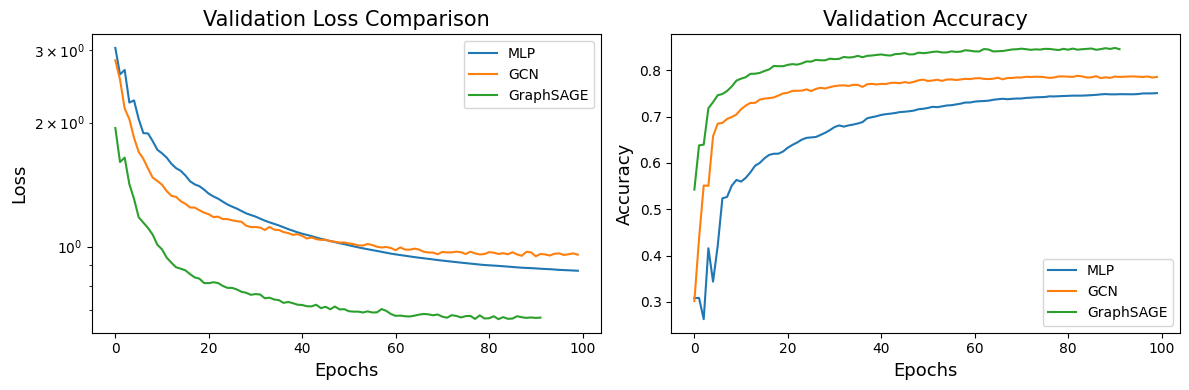

In [ ]:

# Unpack values
mlp_train_loss, mlp_valid_loss, mlp_train_acc, mlp_valid_acc = zip(*mlp_loss)
gcn_train_loss, gcn_valid_loss, gcn_train_acc, gcn_valid_acc = zip(*gcn_loss)
sage_train_loss, sage_valid_loss, sage_train_acc, sage_valid_acc = zip(*sage_loss)

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Plotting Validation Loss
axs[0].semilogy(mlp_valid_loss, label='MLP')
axs[0].semilogy(gcn_valid_loss, label='GCN')
axs[0].semilogy(sage_valid_loss, label='GraphSAGE')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend()
axs[0].set_title('Validation Loss Comparison', fontsize=title_size)

# Plotting Validation Accuracy
axs[1].plot(mlp_valid_acc, label='MLP')
axs[1].plot(gcn_valid_acc, label='GCN')
axs[1].plot(sage_valid_acc, label='GraphSAGE')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend()
axs[1].set_title('Validation Accuracy', fontsize=title_size)

plt.tight_layout()
plt.show()


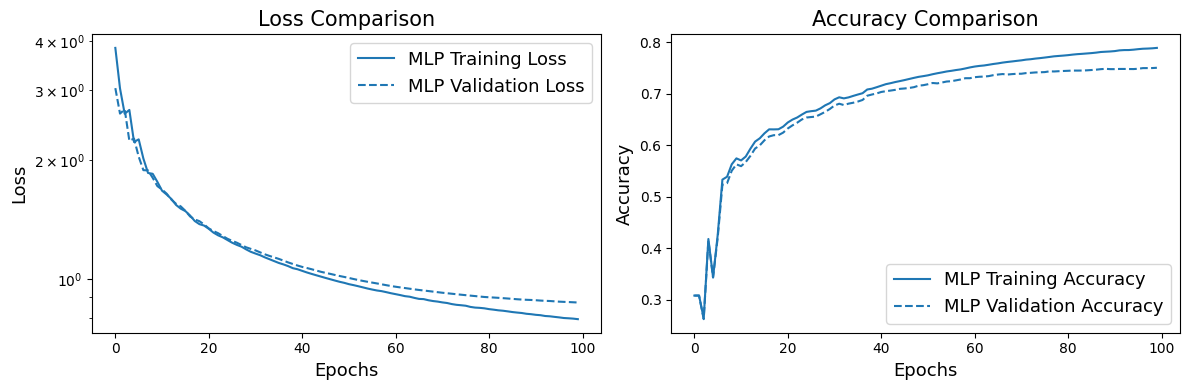

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']

# Convert it to a list and get the colors
colors = prop_cycle.by_key()['color']

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Create a figure for Loss
axs[0].semilogy(mlp_train_loss, '-',color=colors[0], label='MLP Training Loss')
axs[0].semilogy(mlp_valid_loss, '--',color=colors[0], label='MLP Validation Loss')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend(fontsize=label_size)
axs[0].set_title('Loss Comparison', fontsize=title_size)


# Create a figure for Accuracy
axs[1].plot(mlp_train_acc, '-',color=colors[0], label='MLP Training Accuracy')
axs[1].plot(mlp_valid_acc, '--',color=colors[0], label='MLP Validation Accuracy')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend(fontsize=label_size)
axs[1].set_title('Accuracy Comparison', fontsize=title_size)
plt.tight_layout()
plt.show()


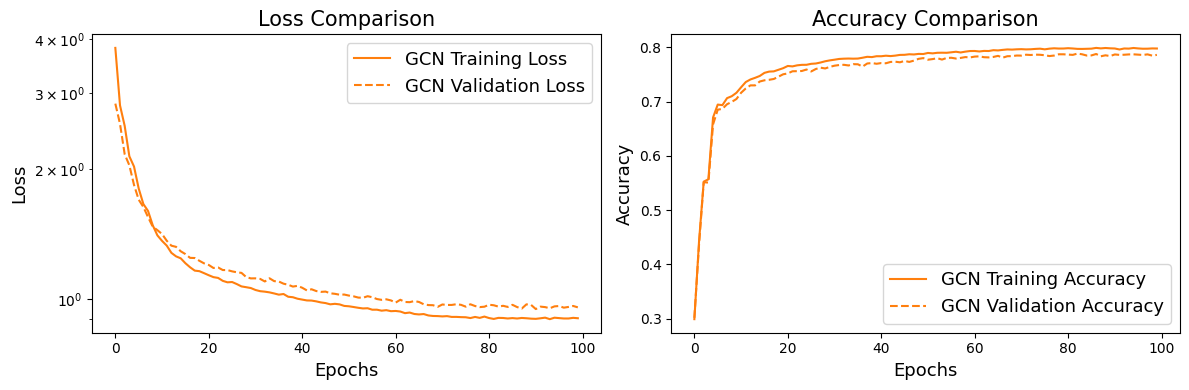

In [ ]:
# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Create a figure for Loss
axs[0].semilogy(gcn_train_loss, '-', color=colors[1], label='GCN Training Loss')
axs[0].semilogy(gcn_valid_loss, '--', color=colors[1], label='GCN Validation Loss')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend(fontsize=label_size)
axs[0].set_title('Loss Comparison', fontsize=title_size)

# Create a figure for Accuracy
axs[1].plot(gcn_train_acc, '-', color=colors[1], label='GCN Training Accuracy')
axs[1].plot(gcn_valid_acc, '--', color=colors[1], label='GCN Validation Accuracy')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend(fontsize=label_size)
axs[1].set_title('Accuracy Comparison', fontsize=title_size)

plt.tight_layout()
plt.show()


In [ ]:
# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Create a figure for Loss
axs[0].semilogy(sage_train_loss, '-', color=colors[2], label='GraphSAGE Training Loss')
axs[0].semilogy(sage_valid_loss, '--', color=colors[2], label='GraphSAGE Validation Loss')
axs[0].set_xlabel('Epochs', fontsize=label_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].legend(fontsize=label_size)
axs[0].set_title('Loss Comparison', fontsize=title_size)

# Create a figure for Accuracy
axs[1].plot(sage_train_acc, '-', color=colors[2], label='GraphSAGE Training Accuracy')
axs[1].plot(sage_valid_acc, '--', color=colors[2], label='GraphSAGE Validation Accuracy')
axs[1].set_xlabel('Epochs', fontsize=label_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].legend(fontsize=label_size)
axs[1].set_title('Accuracy Comparison', fontsize=title_size)

plt.tight_layout()
plt.show()
